In [1]:
import pandas as pd
import pandas_profiling

In [2]:
df_100000 = pd.read_csv("100000 point sample.csv")

In [3]:
df_100000.describe()

,UNIQUE KEY,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
count,1.000000e+05,75826.000000,84570.000000,84570.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.355113e+06,10813.193891,40.723435,-73.921389,0.22949,0.001140,0.05440,0.000750,0.015490,0.000060,0.159600,0.000330
std,2.891480e+04,566.435204,0.076947,0.084744,0.60285,0.034622,0.23618,0.027739,0.124057,0.007746,0.560028,0.019233
min,3.304089e+06,10001.000000,40.499135,-74.253031,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.330089e+06,10075.000000,40.669865,-73.977825,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.355114e+06,11205.000000,40.723022,-73.932663,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.380156e+06,11236.000000,40.766153,-73.868837,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.405174e+06,11697.000000,40.912468,-73.701278,12.00000,2.000000,5.00000,2.000000,2.000000,1.000000,12.000000,2.000000


In [4]:
pandas_profiling.ProfileReport(df_100000)

Number of variables,29
Number of observations,100000
Total Missing (%),28.6%
Total size in memory,22.1 MiB
Average record size in memory,232.0 B
Numeric,12
Categorical,17
Date,0
Text (Unique),0
Rejected,0
Distinct count,6


In [5]:
import seaborn as sns

In [6]:
df_100 = pd.read_csv("100 point sample.csv")

In [7]:
%matplotlib inline

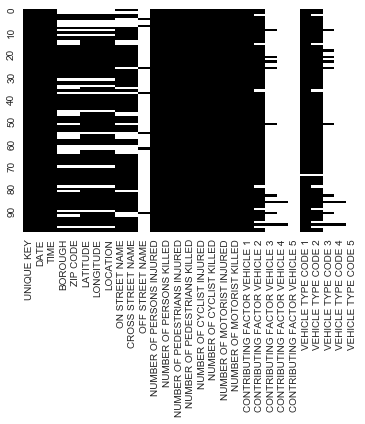

In [8]:
sns.heatmap(df_100.isnull(),
#             yticklabels=False,
            cbar=False,
            vmin=0,
            vmax=1,
            cmap='gray',
            yticklabels=10
#             linewidths=0.5,
#             square=True
           )

In [9]:
df_100.shape[0]

100

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Z is your data set
N = 100
# Z = np.random.random((20,20))
Z = df_100.isnull().values

# G is a NxNx3 matrix
G = np.zeros((df_100.shape[0], df_100.shape[1], 1))

# Where we set the RGB for each pixel
G[Z==True] = [1,1,1]
G[Z==False] = [0,0,0]

plt.imshow(G,interpolation='nearest')
plt.show()

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (846,1)

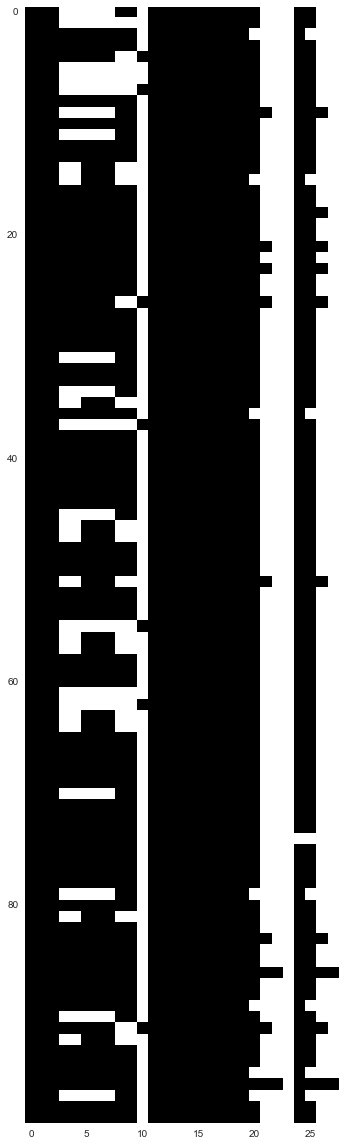

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Z is your data set
N = 100
width = df_100.shape[0]
height = df_100.shape[1]
Z = df_100.isnull().values
# Z = np.random.random((width,height))

# G is a NxNx3 matrix
G = np.zeros((width,height,3))

# Where we set the RGB for each pixel
G[Z>0.5] = [1,1,1]
G[Z<0.5] = [0,0,0]

# fig, ax = subplots(figsize=(18, 2))
# ax.imshow(G, interpolation='nearest')
# tight_layout()

plt.figure(figsize = (8,20))
plt.imshow(G,interpolation='nearest')
plt.grid(False)
plt.show()

In [ ]:
from math import pi

from bokeh.models import HoverTool
from bokeh.plotting import ColumnDataSource, figure, show, output_notebook
from bokeh.sampledata.unemployment1948 import data

data['Year'] = [str(x) for x in data['Year']]

years = list(data['Year'])
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

data = data.set_index('Year')

# this is the colormap from the original NYTimes plot
colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce",
          "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]

# Set up the data for plotting. We will need to have values for every
# pair of year/month names. Map the rate to a color.
month = []
year = []
color = []
rate = []
for y in years:
    for m in months:
        month.append(m)
        year.append(y)
        monthly_rate = data[m][y]
        rate.append(monthly_rate)
        color.append(colors[min(int(monthly_rate)-2, 8)])

source = ColumnDataSource(
    data=dict(month=month, year=year, color=color, rate=rate)
)

TOOLS = "resize,hover,save,pan,box_zoom,wheel_zoom"

p = figure(title="US Unemployment (1948 - 2013)",
           x_range=years, y_range=list(reversed(months)),
           x_axis_location="above", plot_width=900, plot_height=400,
           toolbar_location="left", tools=TOOLS)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi/3

p.rect("year", "month", 1, 1, source=source,
       color="color", line_color=None)

p.select_one(HoverTool).tooltips = [
    ('date', '@month @year'),
    ('rate', '@rate'),
]

output_notebook(hide_banner=True)

show(p)      # show the plot

In [ ]:
height = 500
width = 500
df_100.isnull().shape

In [ ]:
def missingno(df, width=0, height=0, responsive=True):
    plt = figure()
    plt.responsive = responsive
    if width and height:
        plt.plot_width = width
        plt.plot_height = height
    plt.axis.visible = None # Remove axes.
    plt.logo = None # Remove the Bokeh logo.
    plt.outline_line_color = None # Remove border grid.
    plt.xgrid.grid_line_color = None # Remove background x grid.
    plt.ygrid.grid_line_color = None # Remove background y grid.
    plt.min_border_right = plt.min_border_left = plt.min_border_top = plt.min_border_bottom = 0
    
    dat = df.isnull()
    
    mask = np.zeroes(dat.shape)
    
    mask[Z>0.5] = [1,1,1]
G[Z<0.5] = [0,0,0]
    

    plt.rect([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], width=1, height=1, color="navy", alpha=1)
    # show the results
    show(plt)

In [ ]:
missingno(df_100, width=800, height=400)